In [1]:
# log into the virtual coach, update with your credentials
from pynrp.virtual_coach import VirtualCoach
vc = VirtualCoach(environment='local', storage_username='nrpuser')

# disable global logging from the virtual coach
import logging
logging.disable(logging.INFO)

INFO: [2018-04-05 15:51:14,953 - rospy.topics] topicmanager initialized


INFO: [2018-04-05 15:51:15,104 - Configuration] Loading configuration file config.json
INFO: [2018-04-05 15:51:15,107 - Configuration] Using user specified environment: local
INFO: [2018-04-05 15:51:15,109 - VirtualCoach] Logging into the Storage Server as: nrpuser
········
INFO: [2018-04-05 15:51:17,712 - VirtualCoach] Ready.


In [2]:
# parameterized transfer functions we are testing/optimizing
color_tf = '''
import sensor_msgs.msg
from cv_bridge import CvBridge
import cv2

@nrp.MapRobotSubscriber("camera_left", Topic('/mouse_left_eye/mouse/left_eye', sensor_msgs.msg.Image))
@nrp.MapRobotSubscriber("camera_right", Topic('/mouse_right_eye/mouse/right_eye', sensor_msgs.msg.Image))
@nrp.MapSpikeSource("color_left_eye", nrp.brain.sensors[0], nrp.poisson)
@nrp.MapSpikeSource("color_right_eye", nrp.brain.sensors[1], nrp.poisson)
@nrp.MapVariable("bridge", initial_value=CvBridge())
@nrp.MapRobotPublisher('mask_left', Topic('/mouse_left_eye/mouse/left_eye_mask', sensor_msgs.msg.Image))
@nrp.MapRobotPublisher('mask_right', Topic('/mouse_left_eye/mouse/right_eye_mask', sensor_msgs.msg.Image))
@nrp.Robot2Neuron()
def eye_sensor_transmit_right(t, camera_right, camera_left, color_left_eye, color_right_eye, bridge, mask_left, mask_right):

    def detect_color(image, publisher):
        color_left = color_right = 0

        if not isinstance(image, type(None)):

            # Transform image to HSV (easier to detect colors).
            cv_image = bridge.value.imgmsg_to_cv2(image, "rgb8")
            hsv_image = cv2.cvtColor(cv_image, cv2.COLOR_RGB2HSV)

            # Upper and lower thresholds for color detection, convert RGB to HSV and use
            # a range of SV values as suggested by OpenCV documentation
            h = cv2.cvtColor(np.uint8([[[{r}, {g}, {b}]]]), cv2.COLOR_RGB2HSV)[0][0][0]
            lower_color = np.array([h - 10, 30, 30])
            upper_color = np.array([h + 10, 255, 255])

            # Create a mask where every non color pixel will be a zero, plublish the image.
            mask = cv2.inRange(hsv_image, lower_color, upper_color)
            res = cv2.bitwise_and(cv_image, cv_image, mask=mask)
            publisher.send_message(bridge.value.cv2_to_imgmsg(res, "rgb8"))

            image_size = float(cv_image.shape[0] * cv_image.shape[1])
            if (image_size > 0):
                half = cv_image.shape[1] / 2

                # Get the number of color pixels in the image.
                color_left = float(cv2.countNonZero(mask[:, :half]))
                color_right = float(cv2.countNonZero(mask[:, half:]))

                # We have to mutiply the rate by two since it is for an half image only.
                color_left = 2 * (color_left / image_size)
                color_right = 2 * (color_right / image_size)

        return dict(left=color_left, right=color_right)

    image_results_left = detect_color(camera_left.value, mask_left)
    image_results_right = detect_color(camera_right.value, mask_right)
    color_right_eye.rate = 1000.0 * np.mean(image_results_left['right'] + image_results_right['right'])
    color_left_eye.rate = 1000.0 * np.mean(image_results_left['left'] + image_results_right['left'])
'''

turn_tf = '''
import hbp_nrp_cle.tf_framework as nrp
from hbp_nrp_cle.robotsim.RobotInterface import Topic
import sensor_msgs.msg
import std_msgs.msg

@nrp.MapSpikeSink("left_neuron", nrp.brain.actors[0], nrp.leaky_integrator_alpha)
@nrp.MapSpikeSink("right_neuron", nrp.brain.actors[1], nrp.leaky_integrator_alpha)
@nrp.MapRobotSubscriber("joint_state", Topic('/joint_states', sensor_msgs.msg.JointState))
@nrp.Neuron2Robot(Topic('/robot/mouse_head_joint/cmd_pos', std_msgs.msg.Float64))
def head_twist(t, left_neuron, right_neuron, joint_state):

    #Retrieve the current position to interpolate
    idx = joint_state.value.name.index('mouse_head_joint')
    cur_pos = joint_state.value.position[idx]

    #Calculating the target position: the difference between the left and right neuron output
    if left_neuron.voltage > 1e-12 or right_neuron.voltage > 1e-12:
        data = 50.0 * (left_neuron.voltage - right_neuron.voltage)

        #Interpolate the joint position factorly
        return std_msgs.msg.Float64(({factor} * cur_pos + data) / ({factor} + 1))

    #Default to neutral position if no neuron input
    return std_msgs.msg.Float64(0.0)
'''

In [9]:
# reusable Trial class definition

from gazebo_msgs.srv import SetVisualProperties
import rospy
import time
import csv

class Trial(object):
    '''
    Reusable class to launch a trial of the ExDBraitenbergMouse experiment for optimization.

    Allows the caller to:
        - automate start/stimulus/stop events
        - change the stimulus color
        - write joint data to a given path on disk
        - parameterize the head turning and color detection transfer functions
    '''

    def __init__(self, vc, automate=True, stimulus_color='RedGlow', data_dir = None,
                 turn_tf_params={'factor': 0.0}, color_params={'r': 255, 'g': 0, 'b': 0}):

        # store runtime configuration
        self._automate = automate
        self._stimulus_color = stimulus_color
        self._data_dir = data_dir
        self._done = False

        # launch the experiment and register for status messages
        self.exp_id = vc.clone_experiment_to_storage('ExDBraitenbergMouse')
        self._sim = vc.launch_experiment(self.exp_id)
        self._sim.register_status_callback(self._on_status)

        # "turn off" both displays by setting them to black
        rospy.wait_for_service('/gazebo/set_visual_properties')
        self._color_srv = rospy.ServiceProxy('/gazebo/set_visual_properties', SetVisualProperties)
        self._change_screen('right', False)
        self._change_screen('left', False)

        # configure the transfer functions with parameters and update
        self._sim.edit_transfer_function('eye_sensor_transmit_right', color_tf.format(**color_params))
        self._sim.edit_transfer_function('head_twist', turn_tf.format(**turn_tf_params))

    def run(self):
        '''
        Blocking call, run the experiment until it is terminated.
        '''

        # if this is not an interactive launch intended for a user, automatically start
        if self._automate:
            self._sim.start()

        # wait until the simulation terminates cleanly, blocking call
        while not self._done:
            time.sleep(1.0)

    def _change_screen(self, side, stimulate):

        # convenience inline to set the material color of a display in the scene
        self._color_srv('%s_vr_screen' % side,
                        'body', 'screen_glass', 'material:script:name',
                        'Gazebo/%s' % (self._stimulus_color if stimulate else 'Black'))

    def _on_status(self, msg):
        '''
        Receive and process simulation status events, registered as a callback in constructor.
        '''

        # simulation has been terminated
        if msg['state'] == 'stopped':
            self._done = True
            return

        # simulation timeline events, only disable stimulus and stop when non interactive
        if msg['simulationTime'] == 5.0:
            self._change_screen('right', True)
        elif self._automate and msg['simulationTime'] == 15.0:
            self._change_screen('right', False)
        elif self._automate and msg['simulationTime'] == 20.0:
            self._sim.pause()

            # write all position data to disk if a path was given
            if self._data_dir:
               with open(os.path.join(self._data_dir, 'positions.csv'), 'wb') as f:
                    cf = csv.writer(f)
                    cf.writerows(self._sim.get_csv_data('all_joints_positions.csv'))

            self._sim.stop()

In [10]:
# perform a jitter parameter sweep

import shutil
import os
import progressbar

def investigate_jitter():
    '''
    Perform a parameter sweep for optimal position smoothing/weighting.
    '''

    # delete the last run of results if desired
    root_path = os.path.join(os.path.dirname(os.path.realpath('__file__')), 'jitter_data')
    #shutil.rmtree(root_path, ignore_errors=True)

    # loop through different weighting factors, save results to disk
    factors = [f * 0.5 for f in xrange(0, 8)]
    with progressbar.ProgressBar(max_value=len(factors), redirect_stdout=True) as progress:
        progress.update(0)
        
        for i, f in enumerate(factors):

            # skip existing results if the user didn't delete the prior results above
            data_dir = os.path.join(root_path, str(f))
            if os.path.exists(os.path.join(data_dir, 'positions.csv')):
                continue
            os.makedirs(data_dir)

            # run the trial, wait for clean termination and loop
            Trial(vc, automate=True, data_dir=data_dir, turn_tf_params={'factor': f}).run()
            time.sleep(5)
            progress.update(i + 1)

investigate_jitter()

100% (8 of 8) |###########################| Elapsed Time: 0:00:00 Time: 0:00:00


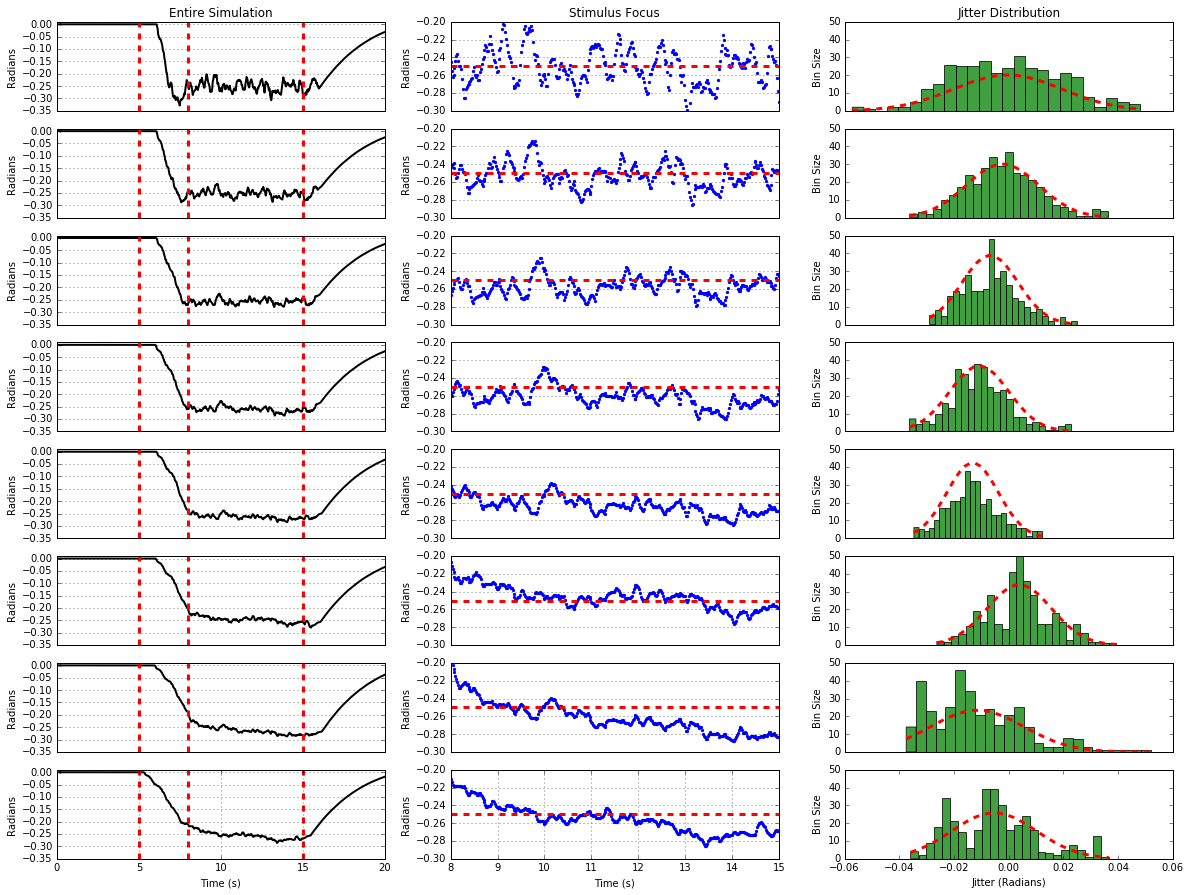

In [11]:
# plot the results of the jitter investigation

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np

def visualize_jitter():
    '''
    Visualize a combined plot displaying gaze jitter in the following formats:
        - full simulation time vs position view
        - zoomed in view of the focus period
        - jitter distribution and curve fit
    '''

    # loop through different weighting factors, save results to disk
    factors = [f * 0.5 for f in xrange(0, 8)]

    # plot position and jitter distribution graphs
    fig, axes = plt.subplots(len(factors), 3)
    root_path = os.path.join(os.path.dirname(os.path.realpath('__file__')), 'jitter_data')
    for i, f in enumerate(factors):
        with open(os.path.join(root_path, str(f), 'positions.csv'), 'rb') as f:

            # read all rows of time and positon data from the csv
            cr = csv.reader(f)
            next(cr, None)
            t = []
            pos = []
            for row in cr:
                t.append(float(row[1]))
                pos.append(float(row[2]))

            # plot the entire simulation duration of time vs joint position
            axes[i, 0].plot(t, pos, color='k', linewidth=2)
            axes[i, 0].axvline(x=5, color='r', linestyle='--', linewidth=3)
            axes[i, 0].axvline(x=8, color='r', linestyle='--', linewidth=3)
            axes[i, 0].axvline(x=15, color='r', linestyle='--', linewidth=3)
            axes[i, 0].grid(True)
            axes[i, 0].set_xlim([0, 20])
            axes[i, 0].set_ylim([-0.35, 0.01])
            axes[i, 0].set_ylabel('Radians')

            # plot the zoomed in view when the neck joint should be centered on the stimulus
            axes[i, 1].scatter(t, pos, color='b', marker='.')
            axes[i, 1].axhline(y=-0.25, color='r', linestyle='--', linewidth=3)
            axes[i, 1].grid(True)
            axes[i, 1].set_xlim([8, 15])
            axes[i, 1].set_ylim([-0.3, -0.2])
            axes[i, 1].set_ylabel('Radians')

            # plot a distribution and curve fit of the jitter vs expected position in radians
            jitters = []
            for x, y in zip(t, pos):
                if x < 8 or x > 15:
                    continue
                jitters.append(y + 0.25)
            n, bins, patches = axes[i, 2].hist(jitters, 25, facecolor='green', alpha=0.75)
            mu = np.mean(jitters)
            sigma = np.std(jitters)
            l = axes[i, 2].plot(bins, mlab.normpdf(bins, mu, sigma), 'r--', linewidth=3)
            axes[i, 2].set_xlim([-0.06, 0.06])
            axes[i, 2].set_ylim([0, 50])
            axes[i, 2].set_ylabel('Bin Size')

    # label and format axes
    axes[0, 0].set_title(label='Entire Simulation')
    axes[0, 1].set_title(label='Stimulus Focus')
    axes[0, 2].set_title(label='Jitter Distribution')

    for y in xrange(len(factors) - 1):
        for x in xrange(3):
            axes[y, x].xaxis.set_visible(False)

    axes[len(factors) - 1, 0].set_xlabel('Time (s)')
    axes[len(factors) - 1, 1].set_xlabel('Time (s)')
    axes[len(factors) - 1, 2].set_xlabel('Jitter (Radians)')

    fig.canvas.set_window_title('Jitter Analysis')
    fig.set_figheight(15)
    fig.set_figwidth(20)
    plt.show()

visualize_jitter()

In [12]:
# perform a high level RGB color sweep for 'SkyBlue' stimulus

def fit_rgb():
    '''
    Perform a parameter sweep to see how different rgb colors influence the experience for a
    desired stimulus.
    '''

    # delete the last run of results
    root_path = os.path.join(os.path.dirname(os.path.realpath('__file__')), 'color_data')
    #shutil.rmtree(root_path, ignore_errors=True)

    # perform a coarse 4x4x4 (64 iteration) high level RGB sweep
    step = 64
    rmin = gmin = bmin = 0
    rmax = gmax = bmax = 255
    i = 0
    with progressbar.ProgressBar(max_value=((rmax/step)+1)**3, redirect_stdout=True) as progress:
        progress.update(0)
        
        for r in xrange(rmin, rmax , step):
            for g in xrange(gmin, gmax , step):
                for b in xrange(bmin, bmax , step):

                    # use the middle of the RGB window, not the extreme edges of the bins
                    rh = r + step / 2
                    gh = g + step / 2
                    bh = b + step / 2

                    # skip existing data if it wasn't deleted above
                    data_dir = os.path.join(root_path, '%s-%s-%s' % (str(rh), str(gh), str(bh)))
                    if os.path.exists(os.path.join(data_dir, 'positions.csv')):
                        continue
                    os.makedirs(data_dir)

                    # run a trial and store the data for this RGB combination response to 'SkyBlue' stimulus
                    Trial(vc, automate=True, data_dir=data_dir, stimulus_color='SkyBlue',
                          turn_tf_params={'factor': 1.5}, color_params={'r': rh, 'g': gh, 'b': bh}).run()
                    time.sleep(5)
                    
                    # update the progress bar
                    i = i + 1
                    progress.update(i)

fit_rgb()

100% (64 of 64) |#########################| Elapsed Time: 0:00:00 Time: 0:00:00


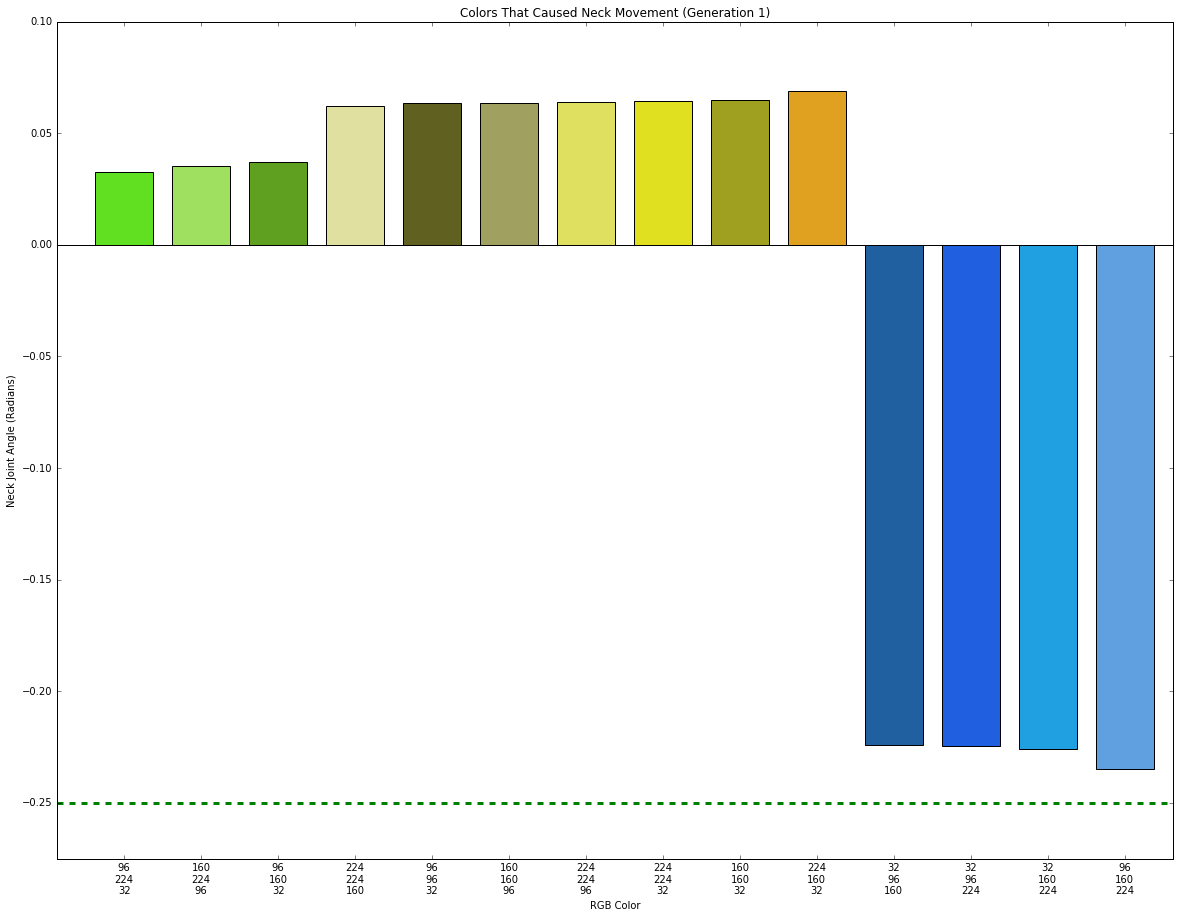

In [ ]:
# visualize the RGB color sweep to see what color parameters resulted in movement

def visualize_rgb():
    '''
    Visualize RGB colors that caused any deflection in neck angle.
    '''

    means = []

    # look at all color_data trails run
    root_path = os.path.join(os.path.dirname(os.path.realpath('__file__')), 'color_data')
    fits = os.listdir(root_path)
    for d in fits:
        with open(os.path.join(root_path, d, 'positions.csv'), 'rb') as f:

            # read the csv, store any values during the focus period of 8-15 seconds
            cr = csv.reader(f)
            next(cr, None)
            focus = []
            for row in cr:
                if float(row[1]) < 8 or float(row[1]) > 15:
                    continue
                focus.append(float(row[2]))

            # if the color has caused movement, store the average and RGB value
            if abs(np.mean(focus)) > 0.01:
                r, g, b = [float(n) / 255.0 for n in d.split('-')]
                means.append([np.mean(focus), (r, g, b)])

    # sort the means by total deflection from stimulus
    means.sort(key=lambda x: abs(x[0]))

    # plot a bar graph with average deflection in the color of the stimulus
    fig, ax = plt.subplots()
    ax.bar(np.arange(len(means)), [m[0] for m in means], 0.75, color=[m[1] for m in means])
    ax.set_xlim(-0.5, len(means))
    ax.set_ylim(-0.275, 0.1)

    # lines for neutral 0 position and target angle
    ax.axhline(y=0, color='k', linestyle='-')
    ax.axhline(y=-0.25, color='g', linestyle='--', linewidth=3)

    # label the bar plots with their real RGB values
    ax.set_xticks([x + 0.75 / 2 for x in np.arange(len(means))])
    ax.set_xticklabels(['%i\n%i\n%i' % (int(m[1][0] * 255), int(m[1][1] * 255), int(m[1][2] * 255)) for m in means])

    # figure and axes labels
    fig.canvas.set_window_title('Colors That Caused Neck Movement')
    ax.set_title('Colors That Caused Neck Movement (Generation 1)')
    plt.ylabel('Neck Joint Angle (Radians)')
    plt.xlabel('RGB Color')
    fig.set_figheight(15)
    fig.set_figwidth(20)
    plt.show()

visualize_rgb()

In [ ]:
# launch the single generation optimized experiment in interactive mode
logging.disable(logging.NOTSET)
Trial(vc, automate=False, stimulus_color='SkyBlue',
      turn_tf_params={'factor': 2.0}, color_params={'r': 96, 'g': 160, 'b': 224}).run()

INFO: [2018-04-05 15:53:33,138 - VirtualCoach] Retrieving list of experiments.
INFO: [2018-04-05 15:53:33,179 - VirtualCoach] Experiment "ExDBraitenbergMouse" cloned successfully
INFO: [2018-04-05 15:53:33,181 - VirtualCoach] Preparing to launch braitenberg_mouse_0.
INFO: [2018-04-05 15:53:33,182 - VirtualCoach] Retrieving list of experiments.
INFO: [2018-04-05 15:53:33,189 - VirtualCoach] Retrieving list of available servers.
[{u'gzweb': {u'assets': u'http://localhost:8080/assets',
             u'nrp-services': u'http://localhost:8080',
             u'videoStreaming': u'http://localhost:8080/webstream/',
             u'websocket': u'ws://localhost:8080/gzbridge'},
  u'id': u'localhost',
  u'rosbridge': {u'websocket': u'ws://localhost:8080/rosbridge'},
  u'serverJobLocation': u'local'}]
INFO: [2018-04-05 15:53:33,195 - Simulation] Attempting to launch braitenberg_mouse_0 on localhost.
INFO: [2018-04-05 15:53:41,516 - Simulation (braitenberg_mouse_0 - localhost #0)] Simulation Successfu